In [1]:
import tensorflow as tf         
from keras.layers import BatchNormalization, LeakyReLU, Add
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense, Activation, Reshape
from keras.models import Input, Model
from keras.optimizers import Adam

from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
K.set_session(sess)
import os

if not os.path.isdir("./collected_data"):
    os.makedirs("./collected_data")
    
if not os.path.isdir("./collected_models"):
    os.makedirs("./collected_models")

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image as IM

from keras.preprocessing.image import ImageDataGenerator, array_to_img

% matplotlib inline

Using TensorFlow backend.


In [2]:
num_image = 50000

In [3]:
def add_images_from_files_to_list(root, files, list, next_index, data_cb=None):
    if files and next_index < num_image:
        def identity(v):
            return v

        if data_cb is None:
            data_cb = identity

        for index, file in enumerate(files):
            if file.endswith('.png'):
                image = IM.load_img(os.path.join(root, file))
                if image is not None and next_index < num_image:
                    list[next_index] = data_cb(image.reshape((64, 64, 3)))
                    next_index += 1
                # list.append(data_cb(image[:, :, 0]))
    return next_index

In [4]:
images_train = np.empty((num_image, 64, 64, 3))
i = 0

In [5]:
for root, sub_directories, files in os.walk(""):
    if i < num_image:
        print(i)
        i = add_images_from_files_to_list(root, files, images_train, i)

# plt.subplot(96, 96)
# plt.imshow(images_train[20], interpolation='nearest', cmap='gray_r')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('./collected_data/gan_generated_image_epoch_%d.png' % 999)
# plt.clf()

In [6]:
# images_train = np.array(images_train)
# images_train = images_train.reshape((*images_train.shape, 1))
# images_train = images_train[:, :, :, :1]

In [11]:
dropout = 0.4
depth = 256
dim = 8
input_dim = 128
batch_size = 1
epochs = 200

In [4]:
class Subpixel(Conv2D):
    def __init__(self,
                 filters,
                 kernel_size,
                 r,
                 padding='same',
                 data_format=None,
                 strides=(1,1),
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Subpixel, self).__init__(
            filters=r*r*filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.r = r

    def _phase_shift(self, I):
        r = self.r
        bsize, a, b, c = I.get_shape().as_list()
        bsize = K.shape(I)[0] # Handling Dimension(None) type for undefined batch dim
        X = K.reshape(I, [bsize, a, b, int(c/(r*r)),r, r]) # bsize, a, b, c/(r*r), r, r
        X = K.permute_dimensions(X, (0, 1, 2, 5, 4, 3))  # bsize, a, b, r, r, c/(r*r)
        #Keras backend does not support tf.split, so in future versions this could be nicer
        X = [X[:,i,:,:,:,:] for i in range(a)] # a, [bsize, b, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, b, a*r, r, c/(r*r)
        X = [X[:,i,:,:,:] for i in range(b)] # b, [bsize, r, r, c/(r*r)
        X = K.concatenate(X, 2)  # bsize, a*r, b*r, c/(r*r)
        return X

    def call(self, inputs):
        return self._phase_shift(super(Subpixel, self).call(inputs))

    def compute_output_shape(self, input_shape):
        unshifted = super(Subpixel, self).compute_output_shape(input_shape)
        return (unshifted[0], int(self.r*unshifted[1]), int(self.r*unshifted[2]), int(unshifted[3]/(self.r*self.r)))

    def get_config(self):
        config = super(Conv2D, self).get_config()
        config.pop('rank')
        config.pop('dilation_rate')
        config['filters']/=int(self.r*self.r)
        config['r'] = self.r
        return config

In [5]:
class AnimeGeneratorFactory():
    def build(self, input_shape):
        """
            Returns a generator Model described here: https://arxiv.org/pdf/1708.05509.pdf
            
            Args:
                input_same: A 3 length tuple describing (width, height, channel)
                
            Output:
                Keras Model
        """
        MOMENTUM = 0.9
        DIM = 16
        DEPTH = 64
        NUM_RESIDUAL = 16
        NUM_SUBPIXEL = 2
        FINAL_FILTERS = 3
        #FINAL_FILTERS = 1
        INITIAL_FILTERS = 64
        def residual_block(layer, filters, momentum):
            """
                Residual Block consisting of
                    Conv2D -> Batch Normalization -> relu -> Conv2D -> Batch Normalization -> Residual Addition
                
                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization
                
                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation('relu')(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = BatchNormalization(momentum=momentum)(layer)

            layer = Add()([layer, shortcut])
            return layer

        def residual_layer(layer, number, filters, momentum):
            """
                Facade for residual block.
                
                Creates Residual layer with specified number of residual blocks
                
                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization
                
                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters, momentum)
            return layer

        def subpixel_block(layer, filters, momentum):
            """
                sub-pixel block consisting of
                    Conv2D -> pixel shuffler x 2 -> Batch Normalization -> Relu
                    
                the code of subpixel layer is based on https://github.com/Tetrachrome/subpixel
                    
                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                    momentum: variable for batch normalization
                
                Returns:
                    Keras layer
            """

            layer = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(layer)
            layer = Subpixel(filters, (3, 3), 2)(layer)

            layer = BatchNormalization(momentum=momentum)(layer)
            layer = Activation('relu')(layer)
            return layer

        def subpixel_layer(layer, number, filters, momentum):
            """
                Facade for subpixel block.
                
                Creates subpixel layer with specified number of subpixel blocks
                
                Args:
                    layer:   Keras layer
                    number:  number of subpixel blocks in layer
                    filters: output size as an integer
                    momentum: variable for batch normalization
                
                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = subpixel_block(layer, filters, momentum)
            return layer
        
        
        inputs = Input(shape=input_shape)
        filters = INITIAL_FILTERS
        layer = Dense(DEPTH * DIM * DIM)(inputs)

        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation('relu')(layer)
        layer = Reshape((DIM, DIM, DEPTH))(layer)
        old = layer
        
        # 16 residual layers
        layer = residual_layer(layer, NUM_RESIDUAL, filters, MOMENTUM)

        layer = BatchNormalization(momentum=MOMENTUM)(layer)
        layer = Activation('relu')(layer)
        layer = Add()([layer, old])

        filters *= 4
        # 3 sub-pixel layers
        layer = subpixel_layer(layer, NUM_SUBPIXEL, filters, MOMENTUM)

        layer = Conv2D(filters=FINAL_FILTERS, kernel_size=(9, 9), strides=(1, 1), padding="same")(layer)
        outputs = Activation('tanh')(layer)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])
        return model

In [6]:
class AnimeDiscriminatorFactory(object):
    """
        Discriminator Factory Class that creates the model described here:
        https://arxiv.org/pdf/1708.05509.pdf
    """

    def build(self, input_shape):
        """
            Returns a Model described here: https://arxiv.org/pdf/1708.05509.pdf
            Args:
                input_same: A 3 length tuple describing (width, height, channel)
            Output:
                Keras Model
        """
        RESIDUAL_BLOCKS_PER_LAYER = 2
        LEAKY_RELU_ALPHA = 0.2
        MODULES = 5

        def intermediate_layer(layer, filters, kernel_size):
            """
                Create the intermediate layers between residual layers.
                Args:
                    layer:       Keras layer
                    filters:     output size as an integer
                    kernel_size: length 2 tuple
                Returns:
                    Keras layer
            """
            layer = Conv2D(filters=filters, kernel_size=kernel_size,
                           strides=(2, 2), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def initial_layer(input_layer):
            """
                Facade for intermediate_layer for the first layer of the network.
                Args:
                    input_layer: Keras Input Layer
                Returns:
                    Keras layer
            """
            INITIAL_LAYER_FILTER = 32
            INITIAL_KERNEL_SIZE = (4, 4)
            return intermediate_layer(input_layer, INITIAL_LAYER_FILTER, INITIAL_KERNEL_SIZE)

        def residual_block(layer, filters):
            """
                Residual Block consisting of
                    Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> Residual Addition
                Args:
                    layer:   Keras Layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            shortcut = layer
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            layer = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=(1, 1), padding="same")(layer)

            layer = Add()([layer, shortcut])
            layer = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(layer)
            return layer

        def residual_layer(layer, number, filters):
            """
                Facade for residual block.
                Creates Residual layer with specified number of residual blocks
                Args:
                    layer:   Keras layer
                    number:  number of residual blocks in layer
                    filters: output size as an integer
                Returns:
                    Keras layer
            """
            for _ in range(number):
                layer = residual_block(layer, filters)
            return layer

        # NOTE: notation kxnysz
        # - k specifies that the convolution layer has kernel_size x
        # - n specifies that the convolution layer has y feature maps
        # - s specifies that the convolution layer has stride z

        inputs = Input(shape=input_shape)

        filters = 32
        # initial layer k4n32s2
        layer = initial_layer(inputs)
        for i in range(MODULES):
            layer = residual_layer(layer, RESIDUAL_BLOCKS_PER_LAYER, filters)
            filters *= 2

            intermediate_kernel_size = (3, 3)
            if i < 2:
                intermediate_kernel_size = (4, 4)
            layer = intermediate_layer(
                layer, filters, intermediate_kernel_size)

        outputs = Dense(1, activation="sigmoid")(layer)
        
        reshaped_output = Reshape((1,))(outputs)

        model = Model(inputs=inputs, outputs=reshaped_output)
        model.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

        return model

In [7]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
train_data_dir = '../dataset-download/faces/'
valid_data_dir = '../dataset-download/faces'

In [12]:
# generator1 = keras_generator()
# generator2 = keras_generator()
# generator3 = keras_generator()

generator = AnimeGeneratorFactory().build([input_dim])
# generator.summary()

ganInput = Input((input_dim,))

# x1 = generator1(ganInput)
# x2 = generator2(ganInput)
# x3 = generator3(ganInput)

x = generator(ganInput)

In [13]:
discriminator = AnimeDiscriminatorFactory().build((64, 64, 3))
# discriminator.summary()
# d_input = keras.layers.concatenate([x1, x2, x3], axis=-1)
# d_input = Reshape((96, 96, 3))(d_input)
# generator = Model(inputs=ganInput, outputs=d_input)
# ganOutput = discriminator(d_input)


In [14]:
ganOutput = discriminator(x)

In [15]:
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [16]:
dLosses = []
gLosses = []

In [17]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    # plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./collected_data/gan_loss_epoch_%d.png' % epoch)
    plt.clf()

In [18]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, input_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 64, 64, 3)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./collected_data/gan_generated_image_epoch_%d.png' % epoch)
    plt.clf()

In [19]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    print("saving")
    generator.save('./collected_models/gan_generator1_epoch_%d.h5' % epoch)
    # generator1.save('./collected_models/gan_generator1_epoch_%d.h5' % epoch)
    # generator2.save('./collected_models/gan_generator2_epoch_%d.h5' % epoch)
    # generator3.save('./collected_models/gan_generator3_epoch_%d.h5' % epoch)
    discriminator.save('./collected_models/gan_discriminator_epoch_%d.h5' % epoch)

In [26]:
def train(epochs=1, batchSize=128):
    batchCount = int(images_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    valid_datagen = ImageDataGenerator(rescale = (1./255))

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(64, 64),
        batch_size=batchSize,
        class_mode='binary')
    
    valid_generator = valid_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(64, 64),
        batch_size=batchSize,
        class_mode='binary')

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        dloss = 0
        gloss = 0
        for batch, label in train_generator:
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            #imageBatch = images_train[np.random.randint(0, images_train.shape[0], size=batchSize)]

            # Generate fake images
            generatedImages = generator.predict(noise)
            # print(np.shape(imageBatch), np.shape(generatedImages))
            images = np.concatenate([batch, generatedImages])        
            # print(X.shape)

            # Labels for generated and real data
            labels = np.concatenate((label, np.ones(batchSize)))
            
            print(images.shape)
            print(labels.shape)
            
            # Train discriminator
            print("discriminator start...", end="")
            discriminator.trainable = True
            (dloss, dAcc) = discriminator.train_on_batch(images, labels)
            print((dloss, dAcc))
            print("done")

            # Train generator
#             print("generator start...", end="")
#             noise = np.random.normal(0, 1, size=[batchSize, input_dim])
#             yGen = np.ones(batchSize)
#             discriminator.trainable = False
#             gloss = gan.train_on_batch(noise, yGen)
# #             print('-'*5, 'Batch %d/%d done' % ((b + 1), batchCount))
#             print("done")
#             break
        
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
#         print("saving generated image...", end="")
#         for i in range(generatedImages.shape[0]):
#             g_image = array_to_img(generatedImages[i])
#             g_image.save("./collected_data/gan_generated_image_epoch_{0}_{1}.png".format(e, i))
#         print("done")
        
        
#         if e == 1 or e % 20 == 0:
#             print("saving model...", end="")
#             saveModels(e)
#             print("done")

        # Plot losses from every epoch
#         print("plotting losses...", end="")
#         plotLoss(e)
#         print("done")

In [27]:
train(1, 32)

Epochs: 1
Batch size: 32
Batches per epoch: 1562
Found 521 images belonging to 1 classes.
Found 521 images belonging to 1 classes.
--------------- Epoch 1 ---------------
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done
(64, 64, 64, 3)
(64,)
discriminator start...(7.9711919, 0.5)
done


KeyboardInterrupt: 

In [23]:
    
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale = (1./255))

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

Found 521 images belonging to 1 classes.


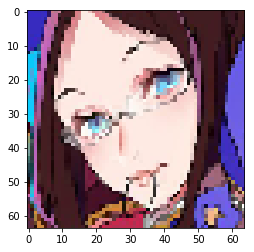

In [50]:

for batch, label in train_generator:
    for img in batch:
        pil_img = array_to_img(img)
        plt.imshow(pil_img)
    break

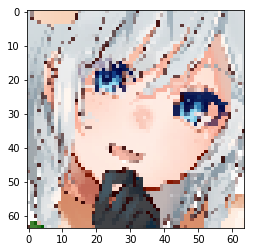

In [33]:
plt.imshow(pil_img)

In [13]:
def data_generator(batch_size, train_data_directory):
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_directory,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='binary')
    
    return train_generator

def build_network(input_shape, noise_shape):
    discriminator = AnimeDiscriminatorFactory().build(input_shape)
    generator = AnimeGeneratorFactory().build(noise_shape)
    
    gan_inputs = Input(noise_shape)
    generator_outputs = generator(gan_inputs)
    gan_outputs = discriminator(generator_outputs)
    gan = Model(inputs=gan_inputs, outputs=gan_outputs)
    gan.compile(loss = "binary_crossentropy",
                optimizer = "adam",
                metrics=["accuracy"])
    return (discriminator, generator, gan)
    
def execute(epochs, batch_size, input_shape, noise_shape, train_generator, discriminator, generator, gan):
    e = 1
    d_losses = []
    g_losses = []
    for batch, label in train_generator:
        dloss = 0
        gloss = 0
        
        print('-'*15, 'Epoch %d' % e, '-'*15)
        
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=(batch_size, ) + noise_shape)
        generated_images = generator.predict(noise)
        images = np.concatenate([batch, generated_images])

        # Labels for generated and real data
        discriminator_labels = np.concatenate((label, np.ones(batch_size)))

        # Train discriminator
        print("discriminator start...", end="")
        discriminator.trainable = True
        d_loss, d_acc = discriminator.train_on_batch(images, discriminator_labels)
        print("done")

        # Train generator
        print("generator start...", end="")
        noise = np.random.normal(0, 1, size=(batch_size, ) + noise_shape)
        discriminator.trainable = False
        g_loss, g_acc = gan.train_on_batch(noise, labels)
        print("done")

        # Store loss of most recent batch from this epoch
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        print("dloss: ", (d_loss, d_acc))
        print("gloss: ", (g_loss, g_acc))

        if e % 1000 == 0:
            print("saving generated image...", end="")
            for i in range(generated_images.shape[0]):
                g_image = array_to_img(generated_images[i])
                g_image.save("./collected_data/gan_generated_image_epoch_{0}_{1}.png".format(e, i))
            print("done")

        if e == 1 or e % 20 == 0:
            print("saving model...", end="")
            saveModels(e)
            print("done")

        # Plot losses from every epoch
        # print("plotting losses...", end="")
        # plotLoss(e)
        # print("done")

        if e >= epochs:
            break
        e += 1
    
def train(epochs, batch_size, input_shape, noise_shape, train_data_directory):
    train_generator = data_generator(batch_size, train_data_directory)
    discriminator, generator, gan = build_network(input_shape, noise_shape)
    execute(epochs, batch_size, input_shape, noise_shape,
            train_generator, discriminator, generator, gan)
    
    

In [14]:
train(1, 1, (64, 64, 3), (1, 1, 128), "../dataset-download/faces/")

Found 521 images belonging to 1 classes.
--------------- Epoch 1 ---------------


KeyboardInterrupt: 

In [ ]:
(2,) + (1, 1, 128)